# Runs on emulator and machine

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create Ansatz and Hamiltonian

In [5]:
import qiskit

from scipy.sparse.linalg import eigsh
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../../")  # go to parent dir
from itertools import permutations, product
import datetime
import scipy.sparse as sp
from time import perf_counter


from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
from Ansaetze import Ansatz
# from Observables import *


# Qiskit import
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_distribution
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp, Pauli, Operator
import qiskit.quantum_info as qinf
from qiskit.quantum_info import entropy

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import re
import matplotlib as mpl

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "14"
mpl.rcParams["font.serif"] = "STIX"
mpl.rcParams["mathtext.fontset"] = "stix"

# Set the font family to a serif font available on your system (e.g., 'Times New Roman')
plt.rcParams["font.serif"] = ["Times New Roman"]

# Disable TeX rendering
plt.rcParams["text.usetex"] = False


def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

## Setup Hamiltonian

### Lattice object

In [7]:
# class input parameters:
n_sites = [3, 2]  # how many sites for every dimension
g = 1
fact_e_op = 1
fact_b_op = 1
m = 2
omega = 1
sl = 1
L = 8
rotors = False
lambd = 1000
encoding = "gray"  ##'ed'#
magnetic_basis = False
pbc = False
puregauge = False
static_charges_values = None  # {(0,0):1,(1,0):-1} #TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian = False
e_op_out_plus = False  # if E out of site n has plus sign
sparse_pauli = False  # false for circuit ansatz
# exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 1

# lattice
latt = HCLattice(n_sites, pbc=pbc, puregauge=puregauge)

# static charge
latt.func_qstatic_dist()  # charge=(1,0))
static_charges_values_input = latt.distances_coord
print(static_charges_values_input, set(latt.r_list))
qstat = static_charges_values_input[-1]

# qstat={(0,0):-1,(2,1):1}
# latt.func_qstatic_dist((2,1),ch_val=2)

[{(0, 0): -1, (0, 1): 1} {(0, 0): -1, (1, 0): 1} {(0, 0): -1, (2, 1): 1}] {1.0, 2.23606797749979}


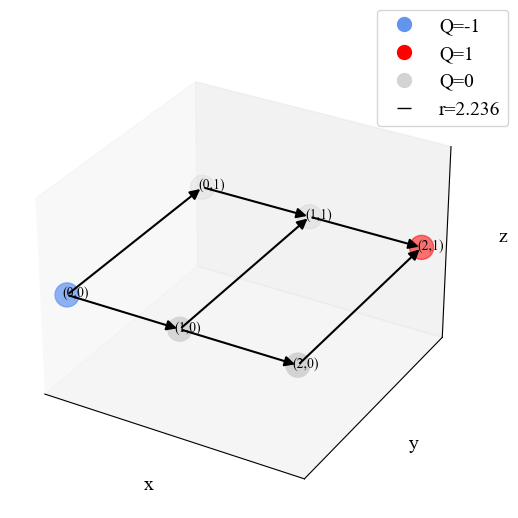

In [8]:
# [latt.draw_graph_func(gauss_law_fig=False,static_charges=st) for st in static_charges_values_input]
latt.draw_graph_func(gauss_law_fig=False, static_charges=qstat)  # ,savefig_dir='.')

## Parametric Hamiltonian

In [9]:
from sympy import Symbol

e_op_free_input = [
    "q_10",
    "q_20",
    "q_21",
    "q_11",
    "q_01",
    "E_10y",
    "E_20y",
]  # if fermions then also put charges!
e_op_free_input = [Symbol(e) for e in e_op_free_input]

# Creating a configuration dictionary with common inputs
config = {
    "latt": latt,
    "n_sites": n_sites,
    "l": sl,
    "L": L,
    "encoding": encoding,
    "magnetic_basis": magnetic_basis,
    "pbc": pbc,
    "puregauge": puregauge,
    "static_charges_values": qstat,
    "e_op_out_plus": e_op_out_plus,
    "e_op_free_input": e_op_free_input,
}
hamilt_sym = HamiltonianQED_sym(config, display_hamiltonian=True)
class_H_oprt = HamiltonianQED_oprt(config, hamilt_sym, sparse_pauli=sparse_pauli)


ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)

n_qubits = int(np.ceil(np.log2(2 * sl + 1)))

Alpha angle α=2 π/2L+1
HamiltonianQED_sym: Initializing...
>> Gauss law system of equations (symbolic + latex):
static charges: ['Q_00=-1', 'Q_21=1']


Eq(-E_00x - E_00y - q_00 + 1, 0)

Eq(E_00y - E_01x - q_01, 0)

Eq(E_00x - E_10x - E_10y - q_10, 0)

Eq(E_01x + E_10y - E_11x - q_11, 0)

Eq(E_10x - E_20y - q_20, 0)

Eq(E_11x + E_20y - q_21 - 1, 0)

Eq(q_00 + q_01 + q_10 + q_11 + q_20 + q_21, 0)

- E_{00x} - E_{00y} - q_{00} + 1 &= 0 \\ \nonumber
E_{00y} - E_{01x} - q_{01} &= 0 \\ \nonumber
E_{00x} - E_{10x} - E_{10y} - q_{10} &= 0 \\ \nonumber
E_{01x} + E_{10y} - E_{11x} - q_{11} &= 0 \\ \nonumber
E_{10x} - E_{20y} - q_{20} &= 0 \\ \nonumber
E_{11x} + E_{20y} - q_{21} - 1 &= 0 \\ \nonumber
q_{00} + q_{01} + q_{10} + q_{11} + q_{20} + q_{21} &= 0 

> Gauss law equations solved
> e_op_free and u_op_free built
>> Hamiltonian (symbolic + latex):


Eq(H_E, g**2*(E_10y**2 + E_20y**2 + (E_20y + q_20)**2 + (-E_20y + q_21 + 1)**2 + (E_10y + E_20y + q_10 + q_20)**2 + (-E_10y - E_20y + q_11 + q_21 + 1)**2 + (-E_10y - E_20y + q_01 + q_11 + q_21 + 1)**2)/2)

H_{E} = \frac{g^{2} \left(E_{10y}^{2} + E_{20y}^{2} + \left(E_{20y} + q_{20}\right)^{2} + \left(- E_{20y} + q_{21} + 1\right)^{2} + \left(E_{10y} + E_{20y} + q_{10} + q_{20}\right)^{2} + \left(- E_{10y} - E_{20y} + q_{11} + q_{21} + 1\right)^{2} + \left(- E_{10y} - E_{20y} + q_{01} + q_{11} + q_{21} + 1\right)^{2}\right)}{2}


Eq(H_B, -(U_10y + U_20y*Dagger(U_10y) + h.c.)/(2*g**2))

H_{B} = - \frac{U_{10y} + U_{20y} U_{10y}^{\dagger} + h.c.}{2 g^{2}}


Eq(H_K, Omega*(-0.5*(h.c.(y) + Dagger(Phi_1)*Phi_6 - Dagger(Phi_2)*Dagger(U_10y)*Phi_5 + Dagger(Phi_3)*Dagger(U_20y)*Phi_4) + 0.5*I*(-h.c.(x) + Dagger(Phi_1)*Phi_2 + Dagger(Phi_2)*Phi_3 + Dagger(Phi_5)*Phi_4 + Dagger(Phi_6)*Phi_5)))

H_{K} = \Omega \left(- 0.5 \left(h.c.(y) + \Phi_{1}^{\dagger} \Phi_{6} - \Phi_{2}^{\dagger} U_{10y}^{\dagger} \Phi_{5} + \Phi_{3}^{\dagger} U_{20y}^{\dagger} \Phi_{4}\right) + 0.5 i \left(- h.c.(x) + \Phi_{1}^{\dagger} \Phi_{2} + \Phi_{2}^{\dagger} \Phi_{3} + \Phi_{5}^{\dagger} \Phi_{4} + \Phi_{6}^{\dagger} \Phi_{5}\right)\right)


Eq(H_m, m*(Dagger(Phi_1)*Phi_1 - Dagger(Phi_2)*Phi_2 + Dagger(Phi_3)*Phi_3 - Dagger(Phi_4)*Phi_4 + Dagger(Phi_5)*Phi_5 - Dagger(Phi_6)*Phi_6))

H_{m} = m \left(\Phi_{1}^{\dagger} \Phi_{1} - \Phi_{2}^{\dagger} \Phi_{2} + \Phi_{3}^{\dagger} \Phi_{3} - \Phi_{4}^{\dagger} \Phi_{4} + \Phi_{5}^{\dagger} \Phi_{5} - \Phi_{6}^{\dagger} \Phi_{6}\right)
>> Gauss law applied and Hamiltonian built.  Execution time: 0.11305713653564453 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
Hamiltonian_el_pauli done
>> Hamiltonian built.  Execution time: 4.781197786331177 seconds
Hamiltonian suppr fermions...
Hamiltonian suppr fermions done
>> Suppression term built.  Execution time: 0.006662845611572266 seconds


### Check properties of Hamiltonian

In [10]:
Hamiltonian_Pauli_tot_vqd = class_H_oprt.get_hamiltonian(
    g_var=g, m_var=m, omega=omega, fact_b_op=fact_b_op, fact_e_op=fact_b_op, lambd=0
).simplify()
print(
    "Partition a SparsePauliOp into sets of commuting Pauli strings:",
    len(Hamiltonian_Pauli_tot_vqd.group_commuting()),
)

Partition a SparsePauliOp into sets of commuting Pauli strings: 8


In [11]:
(
    class_H_oprt.qop_list[::-1] + class_H_oprt.uop_list[::-1]
)  # order of operators in tensor product and on circuit little endian ..q2q1q0

[q_01, q_11, q_21, q_20, q_10, q_00, U_20y, U_10y]

In [12]:
# print('or charges')
for i, k in enumerate(class_H_oprt.uop_list + class_H_oprt.qop_list):
    print(f"qubit{i}:{k}")

qubit0:U_10y
qubit1:U_20y
qubit2:q_00
qubit3:q_10
qubit4:q_20
qubit5:q_21
qubit6:q_11
qubit7:q_01


## Quantum circuit: with fermions

### Parametric ansatz circuit in `qiskit`

In [13]:
nlayers = 1
entanglement = "full"  # triangular,linear,full
rzlayer = False
ansatz_class = Ansatz(
    sl,
    ngauge,
    nfermions=n_qubits_f,
    gauge_list=class_H_oprt.uop_list,
    ferm_list=class_H_oprt.qop_list,
)


def params(i):
    return Parameter(f"θ[{i}]")


qc_gauge, first_layer_par, th_gauge = ansatz_class.puregauge_circuit_entang(
    entanglement=entanglement, rzlayer=rzlayer, nlayers=nlayers
)

qreg_g = []
qreg_f = []
if ansatz_class.gauge_list:
    for i in [str(k) for k in ansatz_class.gauge_list]:
        qreg_g.append(QuantumRegister(ansatz_class.n_qubits, name=i))
else:
    for i in range(ansatz_class.ngauge):
        qreg_g.append(QuantumRegister(ansatz_class.n_qubits, name=f"g{i}"))
if ansatz_class.ferm_list:
    for f in [str(i) for i in ansatz_class.ferm_list]:
        qreg_f.append(QuantumRegister(1, name=f))
else:
    for i in range(ansatz_class.nfermions):
        qreg_f.append(QuantumRegister(1, name=f"f{i}"))

qc_tot2 = QuantumCircuit(*qreg_g, *qreg_f)

# gauge part
qc_tot2.compose(
    qc_gauge, range(ansatz_class.ngauge * ansatz_class.n_qubits), inplace=True
)

# fermionic part
qc_ferm, th = ansatz_class.fermionic_circuit(th_ferm=th_gauge, nlayers=2)
qc_tot2.compose(
    qc_ferm,
    range(
        ansatz_class.ngauge * ansatz_class.n_qubits,
        ansatz_class.ngauge * ansatz_class.n_qubits + ansatz_class.nfermions,
    ),
    inplace=True,
)

qc_tot2.barrier()

for pair in [[0, 5, 8], [1, 5, 8], [2, 6, 7], [3, 6, 7]]:
    qc_tot2.append(Ansatz.CiSwap2(params(th)), pair)
    th += 1

# rz layer for fermions
for i in range(
    ansatz_class.ngauge * ansatz_class.n_qubits,
    ansatz_class.ngauge * ansatz_class.n_qubits + ansatz_class.nfermions,
):
    qc_tot2.rz(params(th), i)
    th += 1

In [16]:
from pytket.extensions.qiskit.qiskit_convert import qiskit_to_tk
from pytket.circuit.display import render_circuit_jupyter
from pytket.circuit import Circuit, Qubit
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import gate_counts, QubitPauliOperator
from pytket.passes import DecomposeBoxes
from collections import defaultdict

In [17]:
pauli_sym = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}


def qps_from_sparsepauliop(paulis):
    """Convert SparsePauliOp tensor of Paulis to pytket QubitPauliString."""
    qlist = []
    plist = []
    for q, p in enumerate(paulis[::-1]):  # XXX little endian qubits
        if p != "I":
            qlist.append(Qubit(q))
            plist.append(pauli_sym[p])
    return QubitPauliString(qlist, plist)


def qpo_from_sparsepauliop(sp_op):
    """Convert SparsePauliOp QubitOperator to pytket QubitPauliOperator."""
    tk_op = defaultdict(complex)
    for term, coeff in sp_op.to_list():
        string = qps_from_sparsepauliop(term)
        tk_op[string] += coeff
    return QubitPauliOperator(tk_op)

## Read data for VQE

In [18]:
# read data from file
def read_datafile_glist(filetxt, nshots=None):
    """Read data from files with VQE and exact diagonalisation results.
    Function specific for that type of files."""
    filename = filetxt  # Replace this with the actual path to your file

    # Define regular expressions to extract the required data
    pattern_g = r"g=(-?\d+\.\d+)"
    pattern_ed = r"ed0=(-?\d+\.\d+)"
    pattern_ed_dict = r"ed_dict=\{([\s\S]+?)\}"

    pattern_vqd = r"vqe0=(-?\d+\.\d+)"
    pattern_vqd_dict = r"vqe_dict=\{([\s\S]+?)\}"
    if nshots:
        pattern_std_dev = r"std_dev=(-?\d+\.\d+)"
    pattern_fidelity = r"fidelity=(\d+\.\d+)"
    pattern_parameters = r"optimal_point=\[([\s\d\.\-\+eE]+)\]"

    g_values = []
    ed_values = []
    dict_ed = []
    vqe_values = []
    dict_vqe = []
    std_dev_values = []
    fidelity_values = []
    parameters_values = []

    with open(filename, "r") as file:
        data = file.read()

        g_values = np.array(list(map(float, re.findall(pattern_g, data))))

        # Extract E_0(ED) values
        ed_values = np.array(list(map(float, re.findall(pattern_ed, data))))

        # Extract E_0(VQD) values
        vqe_values = np.array(list(map(float, re.findall(pattern_vqd, data))))

        for k, g in enumerate(g_values):
            # Extract dict_ed string
            list_ed_tmp = [el for el in re.findall(pattern_ed_dict, data)[k].split()]
            # dict index even keys , index odd values
            dict_ed_tmp = {
                eval(list_ed_tmp[i][:-1]): eval(list_ed_tmp[i + 1])
                for i in range(0, len(list_ed_tmp), 2)
            }
            dict_ed_tmp = {
                key: float(v[0]) if isinstance(v, tuple) else float(v)
                for key, v in dict_ed_tmp.items()
            }

            dict_ed.append(dict_ed_tmp)

            # Extract dict_vqe string
            list_vqd_tmp = [el for el in re.findall(pattern_vqd_dict, data)[k].split()]
            # dict index even keys , index odd values
            dict_vqe_tmp = {
                eval(list_vqd_tmp[i][:-1]): eval(list_vqd_tmp[i + 1])
                for i in range(0, len(list_vqd_tmp), 2)
            }
            dict_vqe_tmp = {
                key: float(v[0]) if isinstance(v, tuple) else float(v)
                for key, v in dict_vqe_tmp.items()
            }

            dict_vqe.append(dict_vqe_tmp)

        # Extract std. dev. values
        std_dev_values = np.array(list(map(float, re.findall(pattern_std_dev, data))))

        # Extract Fidelity (|psi_VQDXpsi_ED|^2) values
        fidelity_values = np.array(list(map(float, re.findall(pattern_fidelity, data))))

        # Extract Parameters values
        parameters_matches = re.finditer(pattern_parameters, data)
        # print(parameters_matches)

        parameters_list = [
            np.array(list(map(float, match.group(1).split())))
            for match in parameters_matches
        ]

    return (
        g_values,
        ed_values,
        dict_ed,
        vqe_values,
        std_dev_values,
        dict_vqe,
        fidelity_values,
        parameters_list,
    )

g2=0.10: Higher fidelity 1st case: 0.9627 > 0.954
g2=0.30: Higher fidelity 2st case: 0.9703 < 0.9706
g2=0.50: Higher fidelity 2st case: 0.9717 < 0.9733
g2=0.70: Higher fidelity 1st case: 0.973 > 0.9728
g2=0.90: Higher fidelity 2st case: 0.9688 < 0.969
g2=1.10: Higher fidelity 1st case: 0.9646 > 0.9635
g2=1.30: Higher fidelity 2st case: 0.9512 < 0.9554
g2=1.50: Higher fidelity 2st case: 0.9246 < 0.9477
g2=1.70: Higher fidelity 2st case: 0.9008 < 0.9482
g2=1.90: Higher fidelity 1st case: 0.9983 > 0.0002
g2=2.10: Higher fidelity 1st case: 0.9989 > 0.0001
g2=2.30: Higher fidelity 1st case: 0.9993 > 0.0001
g2=2.50: Higher fidelity 1st case: 0.9996 > 0.0002
g2=2.70: Higher fidelity 1st case: 0.9996 > 0.0006
g2=2.90: Higher fidelity 1st case: 0.9997 > 0.0015
g2=3.10: Higher fidelity 1st case: 0.9998 > 0.0023


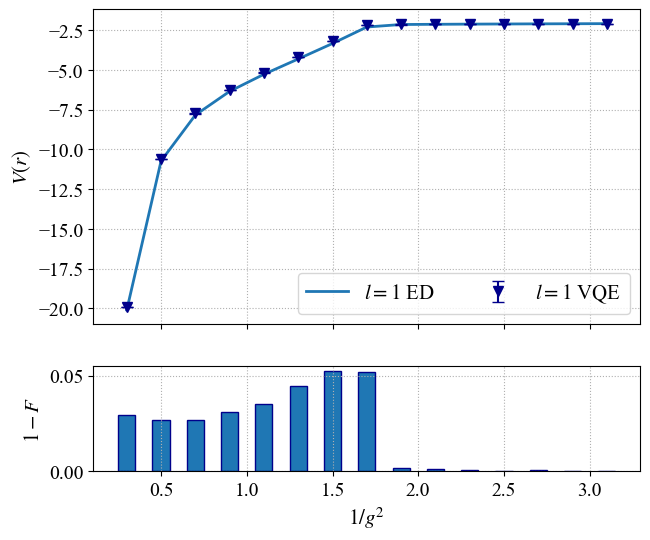

In [20]:
# Read data file
nshots = 10_000  # shots used
(
    g_values_file,
    ed_values_file,
    dict_ed_file,
    vqe_values_file,
    std_dev_values_file,
    dict_vqe_file,
    fidelity_values_file,
    parameters_list_file,
) = read_datafile_glist(
    "static_potential_3x2_m2_omega1_l1_mutualinfoansatz.txt", nshots=nshots
)
(
    g_values_file_v2,
    ed_values_file_v2,
    dict_ed_file_v2,
    vqe_values_file_v2,
    std_dev_values_file_v2,
    dict_vqe_file_v2,
    fidelity_values_file_v2,
    parameters_list_file_v2,
) = read_datafile_glist(
    "static_potential_3x2_m2_omega1_l1_mutualinfoansatz_v2.txt", nshots=nshots
)

width = 510
# select in the two files which one has hogher fidelity in the results. The difference is related to the choice of the initial point.
for fid, fid_2, i in zip(
    fidelity_values_file, fidelity_values_file_v2, range(len(g_values_file))
):
    if fid >= fid_2:  # first run with final string break configuration as initial point
        print(
            f"g2={g_values_file[i]:.2f}: Higher fidelity 1st case: {np.round(fid, 4)} > {np.round(fid_2, 4)}",
        )
    else:  # second run with 4 configurations vacuum for sites and all cases for gauge fields
        print(
            f"g2={g_values_file[i]:.2f}: Higher fidelity 2st case: {np.round(fid, 4)} < {np.round(fid_2, 4)}",
        )
        g_values_file[i] = g_values_file_v2[i]
        ed_values_file[i] = ed_values_file_v2[i]
        dict_ed_file[i] = dict_ed_file_v2[i]
        vqe_values_file[i] = vqe_values_file_v2[i]
        dict_vqe_file[i] = dict_vqe_file_v2[i]
        std_dev_values_file[i] = std_dev_values_file_v2[i]
        fidelity_values_file[i] = fidelity_values_file_v2[i]
        parameters_list_file[i] = parameters_list_file_v2[i]


fig, ax = plt.subplots(
    2,
    figsize=(set_size(width)[0], 6),
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},
)

ax[0].plot(
    g_values_file[1:],
    ed_values_file[1:],
    markersize=6,
    markeredgewidth=2,
    label="$l=1$ ED",
    linewidth=2,
)
ax[0].errorbar(
    g_values_file[1:],
    vqe_values_file[1:],
    yerr=std_dev_values_file[1:],
    marker="v",
    markersize=7,
    color="darkblue",
    label="$l=1$ VQE",
    linestyle="",
    capsize=4,
)
ax[0].set_ylabel(r"$V(r)$", fontsize=15)
ax[0].legend(fontsize=15, ncols=3, loc="lower right")

# ax[1].bar(g_list,np.abs(np.array(vqe_results)-np.array(ed_results)/np.array(ed_results)), edgecolor='black',width=0.1)
ax[1].bar(
    g_values_file[1:], 1 - fidelity_values_file[1:], edgecolor="darkblue", width=0.1
)

ax[1].set_ylabel(r"$1-F$", fontsize=15)
ax[1].set_xlabel(r"$1/g^2$", fontsize=15)


for i in [0, 1]:
    ax[i].grid(True, which="both", linestyle="dotted")

## Using `pytket-quantinuum` to run on H-series

Here we start by using the local emulator (noiseless). Install it with `pip install pytket-quantinuum[pecos]`
(or `pip install pytket-quantinuum\[pecos\]` depending on your terminal shell): [see this website](https://cqcl.github.io/pytket-quantinuum/api/#local-emulators)

In [21]:
from pytket.extensions.quantinuum import QuantinuumBackend, QuantinuumAPIOffline

api_offline = QuantinuumAPIOffline()
backend = QuantinuumBackend(device_name="H1-1LE", api_handler=api_offline) # no need for email access because this is a local noiseless emulator.


In [22]:
circuit = qiskit_to_tk(qc_tot2.assign_parameters(parameters_list_file[0]))
# map between qubits of the old circuit and the new circuit
new_circuit = Circuit(len(circuit.qubits))
orig = circuit.qubits
new = new_circuit.qubits
map_rename = {
    orig[0]: new[0],
    orig[1]: new[1],
    orig[2]: new[2],
    orig[3]: new[3],
    orig[4]: new[4],
    orig[6]: new[5],
    orig[8]: new[6],
    orig[9]: new[7],
    orig[7]: new[8],
    orig[5]: new[9],
}
circuit.rename_units(map_rename)
render_circuit_jupyter(circuit)


In [23]:
circ_compiled = backend.get_compiled_circuit(
    circuit.measure_all(), optimisation_level=2
)

In [24]:
from pytket.circuit import OpType

print(f"Our circuit has {circ_compiled.n_gates} quantum gates in total and an overall")
print(f"depth of {circ_compiled.depth()}.")
print(f"Total number of 2qb gates is {circ_compiled.n_2qb_gates()}")
print(
    f"Of these gates {circ_compiled.n_gates_of_type(OpType.ZZMax)} are two qubit gate, ZZMax, counts."
)
print(
    f"Of these gates {circ_compiled.n_gates_of_type(OpType.ZZPhase)} are two qubit gate, ZZPhase, counts."
)

Our circuit has 246 quantum gates in total and an overall
depth of 68.
Total number of 2qb gates is 81
Of these gates 0 are two qubit gate, ZZMax, counts.
Of these gates 81 are two qubit gate, ZZPhase, counts.


In [67]:
average_angle = []
for com in circ_compiled:  # equivalently, circ.get_commands()
    # print(com.op, com.op.type, com.args, com.op.params)
    if com.op.type == OpType.ZZPhase:
        print(com.op.params)
        average_angle += com.op.params

[0.1751581731550137]
[0.019442975371105436]
[0.4678563763893746]
[0.008079592136490527]
[0.08660958803461982]
[0.019442975371105398]
[0.4678563763893746]
[0.008079592136490454]
[0.09142516365761244]
[3.9805570246288946]
[0.4678563763893745]
[0.008079592136490454]
[0.5]
[0.14005666251742183]
[0.3143947405310401]
[0.5]
[0.14005666251742177]
[0.3143947405310401]
[0.5]
[0.14005666251742177]
[3.68560525946896]
[0.5]
[0.06283062534363024]
[0.4887270782338269]
[0.004152310464278384]
[0.25]
[0.5]
[0.06283062534363015]
[0.48872707823382644]
[0.004152310464278219]
[0.5]
[0.06283062534363015]
[0.48872707823382644]
[0.004152310464278219]
[0.5]
[0.039418398295048056]
[0.02594476018616348]
[0.5]
[0.03941839829504801]
[0.025944760186163318]
[0.25]
[3.960581601704952]
[3.9740552398138367]
[0.5]
[0.00977581185291723]
[0.5]
[0.009775811852917204]
[0.5]
[0.00977581185291676]
[0.5]
[0.25]
[0.5]
[0.5]
[0.5]
[0.5]
[0.25]
[0.5]
[0.5]
[0.002065292350230801]
[0.00013395479503685123]
[0.5]
[0.5]
[0.002065292350

In [70]:
np.mean(average_angle)

0.44211208835602683

For the local emulator the cost is returned as 0.0. For the real H1-1 emulator (and equivalently for the real H1-1) the cost of $2^{10}$ shots is ~221 HQC and of $2^{13}$ shots is ~1740 HQC

In [ ]:
n_shots = 2**13
cost = backend.cost(
    circ_compiled, n_shots=n_shots, syntax_checker="H1-1SC"
)
print("Cost of experiment in HQCs:", cost)

Cost of experiment in HQCs: 1731.8736


With 10K HQC one can run 45 circuits with $2^{10}$ shots and 5 circuits with $2^{13}$ shots

In [ ]:
print(f"Number of circuits with {n_shots} shots: {int(10000/cost)}")

Number of circuits with 8192 shots: 5


$\left(\frac{5 f_{\text {ave }}^{2 Q}-1}{4}\right)^{N_{2 Q}} \operatorname{Tr}\left[L_d \ldots L_1 \rho L_1^{\dagger} \ldots L_d^{\dagger} O\right]=\left(1-\frac{5}{4}\left(1-f_{\text {ave }}^{2 Q}\right)\right)^{N_{2 Q}} \operatorname{Tr}\left[L_d \ldots L_1 \rho L_1^{\dagger} \ldots L_d^{\dagger} O\right]$

$1-f_{\text {ave }}^{2 Q}$ is reported in the emulator data sheet as `p2 = 0.00138`

In [71]:
p2 = 1.38e-3
N2q = circ_compiled.n_2qb_gates()
print(f"Fidelity factor estimate: {(1-5/4*p2)**N2q}")

Fidelity factor estimate: 0.8694924298233877


In [ ]:
render_circuit_jupyter(circ_compiled)

### Check gates for all circuits

In [72]:
# Select only subset of g for running
indices = np.where(np.arange(len(g_values_file)) % 2 != 0)[0]
g_values_file[indices]

array([0.3, 0.7, 1.1, 1.5, 1.9, 2.3, 2.7, 3.1])

In [73]:
for index, g in zip(indices, g_values_file[indices]):
    print(f"g={np.round(g,2)}")
    circuit = qiskit_to_tk(qc_tot2.assign_parameters(parameters_list_file[index]))
    # map between qubits of the old circuit and the new circuit
    new_circuit = Circuit(len(circuit.qubits))
    orig = circuit.qubits
    new = new_circuit.qubits
    map_rename = {
        orig[0]: new[0],
        orig[1]: new[1],
        orig[2]: new[2],
        orig[3]: new[3],
        orig[4]: new[4],
        orig[6]: new[5],
        orig[8]: new[6],
        orig[9]: new[7],
        orig[7]: new[8],
        orig[5]: new[9],
    }
    circuit.rename_units(map_rename)
    # render_circuit_jupyter(circuit)
    circ_compiled = backend.get_compiled_circuit(
        circuit.measure_all(), optimisation_level=2
    )
    print(f"Total number of 2qb gates is {circ_compiled.n_2qb_gates()}")

g=0.3
Total number of 2qb gates is 80
g=0.7
Total number of 2qb gates is 81
g=1.1
Total number of 2qb gates is 80
g=1.5
Total number of 2qb gates is 81
g=1.9
Total number of 2qb gates is 80
g=2.3
Total number of 2qb gates is 82
g=2.7
Total number of 2qb gates is 81
g=3.1
Total number of 2qb gates is 81


### Emulator runs

In [74]:
machine = "H1-1E"  # real: H1-1

emu_backend = QuantinuumBackend(device_name=machine)
emu_backend.login()  # need to login only once
nshots = 2**10

Best to set up the loop in a way that is only submitting jobs and saving the handle for each job to disk.
Then you can do a second loop that retrieves the results using those handles, once the results are available.

The following functions are from our tutorial [Quantinuum_chemistry_chemically_aware_ucc.ipynb](https://github.com/CQCL/pytket-quantinuum/blob/develop/examples/Quantinuum_chemistry_chemically_aware_ucc.ipynb)

In [83]:
from typing import Dict, List, Tuple

from pytket.circuit import Circuit
from pytket.partition import (
    measurement_reduction,
    MeasurementSetup,
    PauliPartitionStrat,
    MeasurementBitMap,
)

from pytket.backends.resulthandle import ResultHandle
from pytket.utils.operators import QubitPauliOperator


def hamiltonian_averaging_submission(
    state_circuit: Circuit,
    hamiltonian: QubitPauliOperator,
    backend: QuantinuumBackend,
    n_shots: int,
    max_batch_cost: int = 5000,
) -> Tuple[List[ResultHandle], MeasurementSetup]:
    circuit = state_circuit.copy()
    term_list = [term for term in hamiltonian._dict.keys()]
    measurement_setup = measurement_reduction(
        term_list, strat=PauliPartitionStrat.CommutingSets
    )
    handles_list = []
    for i, mc in enumerate(measurement_setup.measurement_circs):
        c = circuit.copy()
        c.append(mc)
        cc = backend.get_compiled_circuit(c, optimisation_level=1)
        if isinstance(backend, QuantinuumBackend):
            if i == 0:
                result_handle_start = backend.start_batch(
                    max_batch_cost,
                    cc,
                    n_shots=n_shots,
                    options={"tket-opt-level": None},
                )
                handles_list += [result_handle_start]
            elif i > 0:
                result_handle = backend.add_to_batch(
                    result_handle_start,
                    cc,
                    n_shots=n_shots,
                    options={"tket-opt-level": None},
                )
                handles_list += [result_handle]
        else:
            result_handle = backend.process_circuit(
                cc, n_shots=n_shots, options={"tket-opt-level": None}
            )
            handles_list += [result_handle]
    return handles_list, measurement_setup


def hamiltonian_averaging_evaluate(
    handles_list: List[ResultHandle],
    measurement_setup: MeasurementSetup,
    hamiltonian: QubitPauliOperator,
    backend: QuantinuumBackend,
) -> float:
    results_list = backend.get_results(handles_list)
    energy = 0
    for qps, bitmap_list in measurement_setup.results.items():
        coeff = hamiltonian.get(qps, 0)
        if np.abs(coeff) > 0:
            value = 0
            for bitmap in bitmap_list:
                result = results_list[bitmap.circ_index]
                distribution = result.get_distribution()
                value += compute_expectation_paulistring(distribution, bitmap)
            energy += value / len(bitmap_list) * coeff
    return energy


def compute_expectation_paulistring(
    distribution: Dict[Tuple[int, ...], float], bitmap: MeasurementBitMap
) -> float:
    value = 0
    for bitstring, probability in distribution.items():
        value += probability * (sum(bitstring[i] for i in bitmap.bits) % 2)
    return ((-1) ** bitmap.invert) * (-2 * value + 1)

Fix one value of the coupling

In [76]:
index = indices[2]
g = g_values_file[indices[2]]
print(f"g={np.round(g,2)}")

g=1.1


Create the circuit

In [77]:
circuit = qiskit_to_tk(qc_tot2.assign_parameters(parameters_list_file[index]))
# map between qubits of the old circuit and the new circuit
new_circuit = Circuit(len(circuit.qubits))
orig = circuit.qubits
new = new_circuit.qubits
map_rename = {
    orig[0]: new[0],
    orig[1]: new[1],
    orig[2]: new[2],
    orig[3]: new[3],
    orig[4]: new[4],
    orig[6]: new[5],
    orig[8]: new[6],
    orig[9]: new[7],
    orig[7]: new[8],
    orig[5]: new[9],
}
circuit.rename_units(map_rename)

True

In [78]:
render_circuit_jupyter(circuit)

Create the Hamiltonian

In [79]:
Hamiltonian_Pauli_tot_vqd = class_H_oprt.get_hamiltonian(
        g_var=g,
        m_var=m,
        omega=omega,
        fact_b_op=fact_b_op,
        fact_e_op=fact_b_op,
        lambd=0,
    ).simplify()
# transform Hamiltonina to pytket
hamiltonian_op = qpo_from_sparsepauliop(Hamiltonian_Pauli_tot_vqd)

In [80]:
hamiltonian_op

{(Yq[4], Yq[5]): 0.250000000000000, (Xq[4], Xq[5]): 0.250000000000000, (Xq[8], Xq[9]): -0.250000000000000, (Yq[8], Yq[9]): -0.250000000000000, (Yq[5], Yq[6]): 0.250000000000000, (Xq[5], Xq[6]): 0.250000000000000, (Xq[7], Xq[8]): -0.250000000000000, (Yq[7], Yq[8]): -0.250000000000000, (Yq[4], Zq[5], Zq[6], Zq[7], Zq[8], Xq[9]): 0.250000000000000, (Xq[4], Zq[5], Zq[6], Zq[7], Zq[8], Yq[9]): -0.250000000000000, (Xq[0], Yq[5], Zq[6], Zq[7], Xq[8]): 0.0625000000000000, (Xq[0], Zq[1], Yq[5], Zq[6], Zq[7], Xq[8]): 0.0625000000000000, (Xq[1], Yq[5], Zq[6], Zq[7], Xq[8]): 0.0625000000000000, (Zq[0], Xq[1], Yq[5], Zq[6], Zq[7], Xq[8]): -0.0625000000000000, (Yq[0], Yq[5], Zq[6], Zq[7], Yq[8]): -0.0625000000000000, (Yq[0], Zq[1], Yq[5], Zq[6], Zq[7], Yq[8]): -0.0625000000000000, (Yq[1], Yq[5], Zq[6], Zq[7], Yq[8]): -0.0625000000000000, (Zq[0], Yq[1], Yq[5], Zq[6], Zq[7], Yq[8]): 0.0625000000000000, (Yq[0], Xq[5], Zq[6], Zq[7], Xq[8]): -0.0625000000000000, (Yq[0], Zq[1], Xq[5], Zq[6], Zq[7], Xq[8])

In [85]:
len(hamiltonian_op.all_qubits)

10

In [81]:
# test expectation value with statevector
hamiltonian_op.state_expectation(
    state=circuit.get_statevector(), qubits=sorted(hamiltonian_op.all_qubits)
).real

-5.140877364539186

Submit jobs for measurements

In [82]:
handles_emulator, measurement_setup = hamiltonian_averaging_submission(circuit, hamiltonian_op, emu_backend, nshots)

In [84]:
handles_emulator

[ResultHandle('8aae728628c94702845b903e62f76069', 'null', 10, '[["c", 0], ["c", 1], ["c", 2], ["c", 3], ["c", 4], ["c", 5], ["c", 6], ["c", 7], ["c", 8], ["c", 9]]'),
 ResultHandle('ca16ce86800842a6b719547121abfa81', 'null', 10, '[["c", 0], ["c", 1], ["c", 2], ["c", 3], ["c", 4], ["c", 5], ["c", 6], ["c", 7], ["c", 8], ["c", 9]]'),
 ResultHandle('df62d087fae34d9f91578ad19a222496', 'null', 10, '[["c", 0], ["c", 1], ["c", 2], ["c", 3], ["c", 4], ["c", 5], ["c", 6], ["c", 7], ["c", 8], ["c", 9]]'),
 ResultHandle('2152340248e44379a234d24af7bc793c', 'null', 10, '[["c", 0], ["c", 1], ["c", 2], ["c", 3], ["c", 4], ["c", 5], ["c", 6], ["c", 7], ["c", 8], ["c", 9]]'),
 ResultHandle('bec3dfc4d265482583775ea5186ebdbd', 'null', 10, '[["c", 0], ["c", 1], ["c", 2], ["c", 3], ["c", 4], ["c", 5], ["c", 6], ["c", 7], ["c", 8], ["c", 9]]'),
 ResultHandle('7588075bbadf4a1684dc63ba9d3da9e4', 'null', 10, '[["c", 0], ["c", 1], ["c", 2], ["c", 3], ["c", 4], ["c", 5], ["c", 6], ["c", 7], ["c", 8], ["c", 9]]')

In [89]:
# write handles to disk for later
import pickle

with open("handles_emulator_g2-1.1_1024shots.pkl","bw") as f:
    pickle.dump(handles_emulator,f)

In [90]:
# read them back
import pickle

with open("handles_emulator_g2-1.1_1024shots.pkl", "br") as f:
    handles_from_disk = pickle.load(f)

In [91]:
handles_from_disk

[ResultHandle('8aae728628c94702845b903e62f76069', 'null', 10, '[["c", 0], ["c", 1], ["c", 2], ["c", 3], ["c", 4], ["c", 5], ["c", 6], ["c", 7], ["c", 8], ["c", 9]]'),
 ResultHandle('ca16ce86800842a6b719547121abfa81', 'null', 10, '[["c", 0], ["c", 1], ["c", 2], ["c", 3], ["c", 4], ["c", 5], ["c", 6], ["c", 7], ["c", 8], ["c", 9]]'),
 ResultHandle('df62d087fae34d9f91578ad19a222496', 'null', 10, '[["c", 0], ["c", 1], ["c", 2], ["c", 3], ["c", 4], ["c", 5], ["c", 6], ["c", 7], ["c", 8], ["c", 9]]'),
 ResultHandle('2152340248e44379a234d24af7bc793c', 'null', 10, '[["c", 0], ["c", 1], ["c", 2], ["c", 3], ["c", 4], ["c", 5], ["c", 6], ["c", 7], ["c", 8], ["c", 9]]'),
 ResultHandle('bec3dfc4d265482583775ea5186ebdbd', 'null', 10, '[["c", 0], ["c", 1], ["c", 2], ["c", 3], ["c", 4], ["c", 5], ["c", 6], ["c", 7], ["c", 8], ["c", 9]]'),
 ResultHandle('7588075bbadf4a1684dc63ba9d3da9e4', 'null', 10, '[["c", 0], ["c", 1], ["c", 2], ["c", 3], ["c", 4], ["c", 5], ["c", 6], ["c", 7], ["c", 8], ["c", 9]]')

We can check the status of the circuits

In [92]:
jobid = emu_backend.get_jobid(handles_from_disk[0])
print(jobid)

8aae728628c94702845b903e62f76069


In [93]:
for h in handles_from_disk:
    circuit_status = emu_backend.circuit_status(h)
    print(circuit_status)

CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='{"name": "circuit-357", "submit-date": "2024-05-07T17:04:44.211593", "result-date": "2024-05-07T17:05:25.110529", "queue-position": null, "cost": "352.136", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)
CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='{"name": "circuit-357", "submit-date": "2024-05-07T17:04:45.407121", "result-date": "2024-05-07T17:06:48.089920", "queue-position": null, "cost": "350.088", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)
CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='{"name": "circuit-357", "submit-date": "2

If circuits are ready we can get the measurements

In [94]:
energies_from_emulator = hamiltonian_averaging_evaluate(
    handles_from_disk, measurement_setup, hamiltonian_op, emu_backend
)

In [100]:
print(f"Energy from statevector=-5.140877364539186 and from emulator={energies_from_emulator}")

Energy from statevector=-5.140877364539186 and from emulator=-3.93455231469525
